<a href="https://colab.research.google.com/github/rashidmeras/EVA5/blob/master/S6/EVA5_Submission_Session_6_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Objective take best 5th code, and run bellow versions for 25 epochs and report findings:

>> 1. with L1 + BN
2. with L2 + BN
3. with L1 and L2 with BN
4. with GBN
5. with L1 and L2 with GBN


* *You need to write a single loop or iterator to iterate through these conditions.*

* Draw ONE graph to show the validation accuracy curves for all 5 jobs above. This graph must have proper legends and it should be clear what we are looking at.

* Draw ONE graph to show the loss change curves for all 5 jobs above. This graph must have proper legends and it should be clear what we are looking at.

* Find any 25 misclassified images (combined into single image) for "with GBN" model. You should be using the saved model from the above jobs.  You MUST show the actual and predicted class names.


Submitted By: 
* `Meras Pillai Rashid`
* `Samir Prasad`


## Import `pytorch` libraries and modules:

In [1]:
from __future__ import print_function
import torch
#import nueral net model in the torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#torchvision is the libraray in torch that has many features
#and we are using datasets and transforms from this library 
from torchvision import datasets, transforms

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls /content/gdrive/My\ Drive/Colab\ Notebooks/EVA5/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
'EVA5: Submission - Session 2.ipynb'
'EVA5: Submission - Session3: PyTorch101.ipynb'
'EVA5: Submission - Session 4.ipynb'
 EVA5:Submission-Session_6_Model-BatchNormalization.pt
 EVA5:Submission-Session_6_Model-GhostBatchNormalization.pt


In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Project Library:

*   Ghost Batch Normalization
*   Misclassified image collection
*   Load the testing and training data with configurabe *batch_size*
*   Plot the Loss and Accuracy Graph
*   Define the structure of the network
*   Setup to create model and summary
*   Load the testing and training data with configurabe *batch_size*
*   Define test and train functions
*   Create a function to *initiate_training* for all conditions





**Ghost Batch Normalization**: 

A technique originally developed for training with very large batch sizes across many accelerators. 

In [5]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
        
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

**Collecting Misclassified Images**

In [6]:
def find_misclassified_image(model, model_path, device, train_loader, image_num, msg):
    
    data_iter = iter(test_loader)
    figure = plt.figure()

    plt.title('Misclassified Images: With {}'.format(msg))
   
    for _i in range(image_num):
          data, target = data_iter.next()

          model.load_state_dict(torch.load(model_path)) 
          model.eval()

          data, target = data.to(device), target.to(device)

          output = model(data)
          pred = output.argmax(dim=1, keepdim=True) 

          for a in range(256):
              if(pred[a]!=target[a]):
                  
                  plt.subplot(5,5,_i+1)
                  plt.axis('off')
                  plt.imshow(data[a].cpu().numpy().squeeze(),cmap='gray_r')                   

Plot the Loss and Accuracy Graph

In [7]:
def plot_stat(stat_list, msg):
    plt.figure(figsize=(20,12))
    plt.plot(stat_list[0],color='Green',   label='With L1+BN')
    plt.plot(stat_list[1],color='Red',     label='With L2+BN')
    plt.plot(stat_list[2],color='Blue',    label='With L1 and L2 with BN')
    plt.plot(stat_list[3],color='Yellow',  label='With GBN')
    plt.plot(stat_list[4],color='Magenta', label='With L1 and L2 with GBN')
        
    plt.xlabel(' Epochs ')

    if msg == 'Loss':
        plt.ylabel(' Loss ')
        plt.title('Total losses vs Epochs')
    elif msg == 'Acc':
        plt.ylabel(' Accuracy ')
        plt.title('Total accuracy vs Epochs')

    plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))
    plt.legend()
    
    plt.show()

Define the structure of the network

In [8]:
# create the instance of the class
class Net(nn.Module):

    #construct the class
    def __init__(self, gbn_en):

        #call parent class and initilize
        super(Net, self).__init__()
        self.gbn_en = gbn_en

        print("Create the instance of the Net class with GBN = {}".format(gbn_en))

        # Layer1:
        if gbn_en:
            self.conv1 = nn.Sequential (nn.Conv2d(1, 32, 3, padding=1),GhostBatchNorm(32,2),nn.ReLU())
        else:  
            self.conv1 = nn.Sequential (nn.Conv2d(1, 32, 3, padding=1),nn.BatchNorm2d(32),nn.ReLU())

        # Layer2: 
        if gbn_en:
            self.conv2 = nn.Sequential (nn.Conv2d(32, 16, 3),GhostBatchNorm(16,2),nn.ReLU())
        else:             
            self.conv2 = nn.Sequential (nn.Conv2d(32, 16, 3),nn.BatchNorm2d(16),nn.ReLU())

        # Max-Pooling layer 
        self.pool1 = nn.MaxPool2d(2, 2)        

        # Layer3:
        if gbn_en:
            self.conv3 = nn.Sequential (nn.Conv2d(16, 8, 1),GhostBatchNorm(8,2),nn.ReLU(),nn.Dropout(0.1))
        else:               
            self.conv3 = nn.Sequential (nn.Conv2d(16, 8, 1),nn.BatchNorm2d(8),nn.ReLU(),nn.Dropout(0.1))

        # Layer4:
        if gbn_en:
            self.conv4 = nn.Sequential (nn.Conv2d(8, 16, 3),GhostBatchNorm(16,2),nn.ReLU())
        else:               
            self.conv4 = nn.Sequential (nn.Conv2d(8, 16, 3),nn.BatchNorm2d(16),nn.ReLU())
            
        # Layer5:
        if gbn_en:
            self.conv5 = nn.Sequential (nn.Conv2d(16, 14, 3),GhostBatchNorm(14,2),nn.ReLU())
        else:          
            self.conv5 = nn.Sequential (nn.Conv2d(16, 14, 3),nn.BatchNorm2d(14),nn.ReLU())

        # Layer6:
        if gbn_en:
            self.conv6 = nn.Sequential (nn.Conv2d(14, 10, 3),GhostBatchNorm(10,2),nn.ReLU())
        else:           
            self.conv6 = nn.Sequential (nn.Conv2d(14, 10, 3),nn.BatchNorm2d(10),nn.ReLU())

        # Layer7:
        self.conv7 = nn.Sequential (nn.Conv2d(10, 10, 1))            

        # GAP Layer
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=7)) # output_size = 1     

    # defines the strcuture of the class
    def forward(self, x):
       
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.gap(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

Setup to create model and summary

In [9]:
def create_model(device, gbn_en):
    model = Net(gbn_en).to(device)
    summary(model, input_size=(1, 28, 28))
    return model

Load the testing and training data with configurabe *batch_size*

In [10]:
def initialize_train_test_loader(batch_size = 128):

    print("\n Initialize train and test loader with Batch Size:{}".format(batch_size))

    torch.manual_seed(22)
    
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                            transforms.RandomRotation((-7.0,7.0), fill=(1,)),                          
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])), batch_size=batch_size, shuffle=True, **kwargs)
       
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])), batch_size=batch_size, shuffle=True, **kwargs)
    
    return train_loader, test_loader



Define test and train functions

In [11]:
from tqdm import tqdm

# Loss train & test
train_losses = []
test_losses = []

# Accuracy train & test
train_acc = []
test_acc = []

# Total Loss & Accuracy
total_losses = []
total_accuracies = []

def train(model, device, train_loader, optimizer, epoch, l1_lambda=None):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # l1 regularization
    if l1_lambda:
        with torch.enable_grad():
            l1_loss=0
            for param in model.parameters():
                l1_loss+=torch.sum(param.abs())
            loss+=l1_lambda*l1_loss  

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))    

Create a function to *initiate_training* for all conditions

In [12]:
from torch.optim.lr_scheduler import StepLR

def initiate_training(model, device, train_loader, epochs, step_lr=True, l1_lambda=None, l2_en=False):

    if l2_en:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=1e-5, nesterov=False)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    if step_lr:
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    
    for epoch in range(epochs):

        train(model, device, train_loader, optimizer, epoch, l1_lambda)

        if step_lr:
            scheduler.step()

        print('\n Epoch {}, lr {}'.format(epoch, optimizer.param_groups[0]['lr']))
        test(model, device, test_loader)    

## Run: Initialization and trainings

Create the model with normal BatchNormalization

In [23]:
model = create_model(device, gbn_en=False)
model_name_bn = "EVA5:Submission-Session_6_Model-BatchNormalization.pt"
save_path_bn = F"/content/gdrive/My Drive/Colab Notebooks/EVA5/{model_name_bn}"
torch.save(model.state_dict(), save_path_bn)
print("Model Saved: {}".format(model_name_bn))

# Set the Epoch
EPOCHS = 25

Create the instance of the Net class with GBN = False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 16, 26, 26]           4,624
       BatchNorm2d-5           [-1, 16, 26, 26]              32
              ReLU-6           [-1, 16, 26, 26]               0
         MaxPool2d-7           [-1, 16, 13, 13]               0
            Conv2d-8            [-1, 8, 13, 13]             136
       BatchNorm2d-9            [-1, 8, 13, 13]              16
             ReLU-10            [-1, 8, 13, 13]               0
          Dropout-11            [-1, 8, 13, 13]               0
           Conv2d-12           [-1, 16, 11, 11]           1,168
      BatchNorm2d-13           [-1, 16, 11, 11]  

1. with L1 + BN


In [24]:
train_loader, test_loader = initialize_train_test_loader()

# with L1 and BN
initiate_training(model, device, train_loader, EPOCHS, False, 1e-5, False)

total_losses.extend([test_losses])
test_losses = []

total_accuracies.extend([test_acc])
test_acc = []

  0%|          | 0/469 [00:00<?, ?it/s]


 Initialize train and test loader with Batch Size:128


Loss=0.3611919581890106 Batch_id=468 Accuracy=68.82: 100%|██████████| 469/469 [02:25<00:00,  3.23it/s]



 Epoch 0, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1860, Accuracy: 9536/10000 (95.36%)



Loss=0.21791507303714752 Batch_id=468 Accuracy=94.39: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 1, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1492, Accuracy: 9569/10000 (95.69%)



Loss=0.07254964858293533 Batch_id=468 Accuracy=95.97: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]



 Epoch 2, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9828/10000 (98.28%)



Loss=0.07323131710290909 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]



 Epoch 3, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9825/10000 (98.25%)



Loss=0.11049054563045502 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 4, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9881/10000 (98.81%)



Loss=0.13049668073654175 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [02:27<00:00,  3.17it/s]



 Epoch 5, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9869/10000 (98.69%)



Loss=0.11518131196498871 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [02:28<00:00,  3.15it/s]



 Epoch 6, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9902/10000 (99.02%)



Loss=0.08327609300613403 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]



 Epoch 7, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9889/10000 (98.89%)



Loss=0.04642203077673912 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]



 Epoch 8, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9885/10000 (98.85%)



Loss=0.150848388671875 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 9, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9873/10000 (98.73%)



Loss=0.0551535040140152 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]



 Epoch 10, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.99%)



Loss=0.14426776766777039 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [02:26<00:00,  3.19it/s]



 Epoch 11, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9892/10000 (98.92%)



Loss=0.028463024646043777 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]



 Epoch 12, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9924/10000 (99.24%)



Loss=0.1265212595462799 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 13, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9918/10000 (99.18%)



Loss=0.04172612726688385 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]



 Epoch 14, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)



Loss=0.12779174745082855 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 15, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9912/10000 (99.12%)



Loss=0.06110382825136185 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]



 Epoch 16, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)



Loss=0.058428213000297546 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [02:25<00:00,  3.21it/s]



 Epoch 17, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9913/10000 (99.13%)



Loss=0.1601795107126236 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s]



 Epoch 18, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9920/10000 (99.20%)



Loss=0.10289578884840012 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s]



 Epoch 19, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9898/10000 (98.98%)



Loss=0.0894220620393753 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 20, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9910/10000 (99.10%)



Loss=0.10561162233352661 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [02:24<00:00,  3.25it/s]



 Epoch 21, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9919/10000 (99.19%)



Loss=0.08377278596162796 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [02:23<00:00,  3.26it/s]



 Epoch 22, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)



Loss=0.0887703225016594 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [02:24<00:00,  3.25it/s]



 Epoch 23, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9918/10000 (99.18%)



Loss=0.06243101879954338 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [02:26<00:00,  3.19it/s]



 Epoch 24, lr 0.01

Test set: Average loss: 0.0201, Accuracy: 9929/10000 (99.29%)



2. with L2 + BN


In [25]:
# with L2 and BN
initiate_training(model, device, train_loader, EPOCHS, False, None, True)

total_losses.extend([test_losses])
test_losses = []

total_accuracies.extend([test_acc])
test_acc = []

Loss=0.055639903992414474 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]



 Epoch 0, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9917/10000 (99.17%)



Loss=0.0171810369938612 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [02:25<00:00,  3.23it/s]



 Epoch 1, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)



Loss=0.025036608800292015 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 2, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)



Loss=0.030438123270869255 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]



 Epoch 3, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)



Loss=0.01743868738412857 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]



 Epoch 4, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)



Loss=0.0661054328083992 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]



 Epoch 5, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)



Loss=0.06798385083675385 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]



 Epoch 6, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)



Loss=0.05949684977531433 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]



 Epoch 7, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)



Loss=0.022733865305781364 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]



 Epoch 8, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)



Loss=0.029572447761893272 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [02:25<00:00,  3.23it/s]



 Epoch 9, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)



Loss=0.061909403651952744 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]



 Epoch 10, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)



Loss=0.013325507752597332 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]



 Epoch 11, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)



Loss=0.038324300199747086 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]



 Epoch 12, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)



Loss=0.049048956483602524 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]



 Epoch 13, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9927/10000 (99.27%)



Loss=0.17053572833538055 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]



 Epoch 14, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)



Loss=0.0904553011059761 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [02:29<00:00,  3.13it/s]



 Epoch 15, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)



Loss=0.030186934396624565 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]



 Epoch 16, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9929/10000 (99.29%)



Loss=0.018321799114346504 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]



 Epoch 17, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)



Loss=0.10948453098535538 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]



 Epoch 18, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)



Loss=0.020479390397667885 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [02:50<00:00,  2.75it/s]



 Epoch 19, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)



Loss=0.055654410272836685 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [02:36<00:00,  3.00it/s]



 Epoch 20, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)



Loss=0.04296468198299408 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [02:30<00:00,  3.12it/s]



 Epoch 21, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)



Loss=0.025548050180077553 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [02:29<00:00,  3.13it/s]



 Epoch 22, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)



Loss=0.014163522981107235 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]



 Epoch 23, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)



Loss=0.02446986921131611 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [02:28<00:00,  3.17it/s]



 Epoch 24, lr 0.01

Test set: Average loss: 0.0196, Accuracy: 9931/10000 (99.31%)



3. with L1 and L2 with BN


In [26]:
# with L1, L2 and BN
initiate_training(model, device, train_loader, EPOCHS, True, 1e-5, True)

total_losses.extend([test_losses])
test_losses = []

total_accuracies.extend([test_acc])
test_acc = []

Loss=0.08596345037221909 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]



 Epoch 0, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)



Loss=0.0515928715467453 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [02:28<00:00,  3.17it/s]



 Epoch 1, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)



Loss=0.04574887454509735 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [02:29<00:00,  3.13it/s]



 Epoch 2, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)



Loss=0.11084309220314026 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [02:27<00:00,  3.17it/s]



 Epoch 3, lr 0.01


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9937/10000 (99.37%)



Loss=0.09272671490907669 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]



 Epoch 4, lr 0.001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)



Loss=0.04923921823501587 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]



 Epoch 5, lr 0.001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)



Loss=0.04496332257986069 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]



 Epoch 6, lr 0.001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)



Loss=0.04247492551803589 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [02:27<00:00,  3.17it/s]



 Epoch 7, lr 0.001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9951/10000 (99.51%)



Loss=0.026370972394943237 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [02:27<00:00,  3.17it/s]



 Epoch 8, lr 0.001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)



Loss=0.03927762061357498 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [02:27<00:00,  3.17it/s]



 Epoch 9, lr 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)



Loss=0.10477827489376068 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [02:30<00:00,  3.12it/s]



 Epoch 10, lr 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)



Loss=0.038820914924144745 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]



 Epoch 11, lr 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)



Loss=0.0990365594625473 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [02:28<00:00,  3.17it/s]



 Epoch 12, lr 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9945/10000 (99.45%)



Loss=0.019604578614234924 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]



 Epoch 13, lr 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9944/10000 (99.44%)



Loss=0.018357641994953156 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [02:28<00:00,  3.15it/s]



 Epoch 14, lr 1e-05


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9944/10000 (99.44%)



Loss=0.0664711594581604 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [02:28<00:00,  3.17it/s]



 Epoch 15, lr 1e-05


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9944/10000 (99.44%)



Loss=0.060257215052843094 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [02:28<00:00,  3.17it/s]



 Epoch 16, lr 1e-05


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)



Loss=0.10205546766519547 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [02:32<00:00,  3.07it/s]



 Epoch 17, lr 1e-05


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9944/10000 (99.44%)



Loss=0.018334034830331802 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]



 Epoch 18, lr 1e-05


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9945/10000 (99.45%)



Loss=0.024528052657842636 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]



 Epoch 19, lr 1.0000000000000002e-06


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)



Loss=0.03430437296628952 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [02:29<00:00,  3.13it/s]



 Epoch 20, lr 1.0000000000000002e-06


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)



Loss=0.08804634213447571 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [02:34<00:00,  3.04it/s]



 Epoch 21, lr 1.0000000000000002e-06


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99.48%)



Loss=0.03663286566734314 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [02:28<00:00,  3.15it/s]



 Epoch 22, lr 1.0000000000000002e-06


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9945/10000 (99.45%)



Loss=0.03036842681467533 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]



 Epoch 23, lr 1.0000000000000002e-06


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9943/10000 (99.43%)



Loss=0.056530650705099106 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [02:28<00:00,  3.17it/s]



 Epoch 24, lr 1.0000000000000002e-07

Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)



Create the model with Ghost BatchNormalization

In [27]:
model = create_model(device, gbn_en=True)
model_name_gbn = "EVA5:Submission-Session_6_Model-GhostBatchNormalization.pt"
save_path_gbn = F"/content/gdrive/My Drive/Colab Notebooks/EVA5/{model_name_gbn}"
torch.save(model.state_dict(), save_path_gbn)
print("Model Saved: {}".format(model_name_gbn))

Create the instance of the Net class with GBN = True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
    GhostBatchNorm-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 16, 26, 26]           4,624
    GhostBatchNorm-5           [-1, 16, 26, 26]              32
              ReLU-6           [-1, 16, 26, 26]               0
         MaxPool2d-7           [-1, 16, 13, 13]               0
            Conv2d-8            [-1, 8, 13, 13]             136
    GhostBatchNorm-9            [-1, 8, 13, 13]              16
             ReLU-10            [-1, 8, 13, 13]               0
          Dropout-11            [-1, 8, 13, 13]               0
           Conv2d-12           [-1, 16, 11, 11]           1,168
   GhostBatchNorm-13           [-1, 16, 11, 11]   

4. with GBN

In [28]:
train_loader, test_loader = initialize_train_test_loader(256)

# with L1 and GBN
initiate_training(model, device, train_loader, EPOCHS, False, 1e-5, False)

total_losses.extend([test_losses])
test_losses = []

total_accuracies.extend([test_acc])
test_acc = []

  0%|          | 0/235 [00:00<?, ?it/s]


 Initialize train and test loader with Batch Size:256


Loss=1.0669801235198975 Batch_id=234 Accuracy=42.83: 100%|██████████| 235/235 [02:25<00:00,  1.62it/s]



 Epoch 0, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.9414, Accuracy: 6982/10000 (69.82%)



Loss=0.35111546516418457 Batch_id=234 Accuracy=85.48: 100%|██████████| 235/235 [02:21<00:00,  1.66it/s]



 Epoch 1, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1816, Accuracy: 9647/10000 (96.47%)



Loss=0.28040623664855957 Batch_id=234 Accuracy=93.14: 100%|██████████| 235/235 [02:21<00:00,  1.66it/s]



 Epoch 2, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1068, Accuracy: 9761/10000 (97.61%)



Loss=0.12047819793224335 Batch_id=234 Accuracy=95.24: 100%|██████████| 235/235 [02:21<00:00,  1.66it/s]



 Epoch 3, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1177, Accuracy: 9668/10000 (96.68%)



Loss=0.21055252850055695 Batch_id=234 Accuracy=95.95: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 4, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9837/10000 (98.37%)



Loss=0.16934631764888763 Batch_id=234 Accuracy=96.35: 100%|██████████| 235/235 [02:21<00:00,  1.66it/s]



 Epoch 5, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9836/10000 (98.36%)



Loss=0.17426234483718872 Batch_id=234 Accuracy=96.76: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 6, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9854/10000 (98.54%)



Loss=0.13099269568920135 Batch_id=234 Accuracy=96.94: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 7, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9882/10000 (98.82%)



Loss=0.07934097945690155 Batch_id=234 Accuracy=97.14: 100%|██████████| 235/235 [02:25<00:00,  1.62it/s]



 Epoch 8, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9879/10000 (98.79%)



Loss=0.0492698960006237 Batch_id=234 Accuracy=97.29: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 9, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9889/10000 (98.89%)



Loss=0.12096796184778214 Batch_id=234 Accuracy=97.45: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 10, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9893/10000 (98.93%)



Loss=0.06004364788532257 Batch_id=234 Accuracy=97.53: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 11, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9868/10000 (98.68%)



Loss=0.09606479108333588 Batch_id=234 Accuracy=97.64: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 12, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9902/10000 (99.02%)



Loss=0.11838331073522568 Batch_id=234 Accuracy=97.56: 100%|██████████| 235/235 [02:24<00:00,  1.62it/s]



 Epoch 13, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9901/10000 (99.01%)



Loss=0.0759323313832283 Batch_id=234 Accuracy=97.60: 100%|██████████| 235/235 [02:24<00:00,  1.63it/s]



 Epoch 14, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9898/10000 (98.98%)



Loss=0.03586895018815994 Batch_id=234 Accuracy=97.81: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 15, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9913/10000 (99.13%)



Loss=0.09551358222961426 Batch_id=234 Accuracy=97.89: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 16, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)



Loss=0.09833601862192154 Batch_id=234 Accuracy=97.80: 100%|██████████| 235/235 [02:24<00:00,  1.63it/s]



 Epoch 17, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99.10%)



Loss=0.09132172912359238 Batch_id=234 Accuracy=97.89: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 18, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9915/10000 (99.15%)



Loss=0.06045548617839813 Batch_id=234 Accuracy=97.92: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 19, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9906/10000 (99.06%)



Loss=0.06493641436100006 Batch_id=234 Accuracy=97.95: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 20, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9900/10000 (99.00%)



Loss=0.06335325539112091 Batch_id=234 Accuracy=97.90: 100%|██████████| 235/235 [02:25<00:00,  1.62it/s]



 Epoch 21, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9903/10000 (99.03%)



Loss=0.03646806627511978 Batch_id=234 Accuracy=98.00: 100%|██████████| 235/235 [02:22<00:00,  1.64it/s]



 Epoch 22, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)



Loss=0.05650339648127556 Batch_id=234 Accuracy=98.10: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 23, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99.19%)



Loss=0.1909923106431961 Batch_id=234 Accuracy=98.02: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 24, lr 0.01

Test set: Average loss: 0.0342, Accuracy: 9890/10000 (98.90%)



5. with L1 and L2 with GBN

In [29]:
# with L1, L2 and GBN
initiate_training(model, device, train_loader, EPOCHS, True, 1e-5, True)

total_losses.extend([test_losses])
test_losses = []

total_accuracies.extend([test_acc])
test_acc = []

Loss=0.14000307023525238 Batch_id=234 Accuracy=98.11: 100%|██████████| 235/235 [02:25<00:00,  1.61it/s]



 Epoch 0, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9922/10000 (99.22%)



Loss=0.17350107431411743 Batch_id=234 Accuracy=98.18: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 1, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)



Loss=0.047834351658821106 Batch_id=234 Accuracy=98.14: 100%|██████████| 235/235 [02:24<00:00,  1.63it/s]



 Epoch 2, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)



Loss=0.05608818680047989 Batch_id=234 Accuracy=98.19: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 3, lr 0.01


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9913/10000 (99.13%)



Loss=0.07378754019737244 Batch_id=234 Accuracy=98.14: 100%|██████████| 235/235 [02:25<00:00,  1.62it/s]



 Epoch 4, lr 0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9899/10000 (98.99%)



Loss=0.05040300637483597 Batch_id=234 Accuracy=98.30: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 5, lr 0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)



Loss=0.05639996752142906 Batch_id=234 Accuracy=98.35: 100%|██████████| 235/235 [02:23<00:00,  1.63it/s]



 Epoch 6, lr 0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)



Loss=0.03008466586470604 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 7, lr 0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)



Loss=0.053199462592601776 Batch_id=234 Accuracy=98.41: 100%|██████████| 235/235 [02:28<00:00,  1.59it/s]



 Epoch 8, lr 0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)



Loss=0.06276807188987732 Batch_id=234 Accuracy=98.51: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 9, lr 0.0001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)



Loss=0.08104562759399414 Batch_id=234 Accuracy=98.53: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 10, lr 0.0001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)



Loss=0.0384456068277359 Batch_id=234 Accuracy=98.49: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 11, lr 0.0001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)



Loss=0.14375244081020355 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [02:25<00:00,  1.62it/s]



 Epoch 12, lr 0.0001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)



Loss=0.07730316370725632 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 13, lr 0.0001


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)



Loss=0.0740806832909584 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 14, lr 1e-05


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)



Loss=0.04283708333969116 Batch_id=234 Accuracy=98.50: 100%|██████████| 235/235 [02:21<00:00,  1.66it/s]



 Epoch 15, lr 1e-05


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)



Loss=0.07100188732147217 Batch_id=234 Accuracy=98.50: 100%|██████████| 235/235 [02:24<00:00,  1.62it/s]



 Epoch 16, lr 1e-05


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)



Loss=0.04815395548939705 Batch_id=234 Accuracy=98.48: 100%|██████████| 235/235 [02:22<00:00,  1.65it/s]



 Epoch 17, lr 1e-05


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)



Loss=0.07750071585178375 Batch_id=234 Accuracy=98.46: 100%|██████████| 235/235 [02:23<00:00,  1.64it/s]



 Epoch 18, lr 1e-05


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)



Loss=0.0922803282737732 Batch_id=234 Accuracy=98.38: 100%|██████████| 235/235 [02:24<00:00,  1.63it/s]



 Epoch 19, lr 1.0000000000000002e-06


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)



Loss=0.05669603496789932 Batch_id=234 Accuracy=98.49: 100%|██████████| 235/235 [02:26<00:00,  1.60it/s]



 Epoch 20, lr 1.0000000000000002e-06


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)



Loss=0.10640650242567062 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [02:23<00:00,  1.63it/s]



 Epoch 21, lr 1.0000000000000002e-06


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)



Loss=0.12003826349973679 Batch_id=234 Accuracy=98.45: 100%|██████████| 235/235 [02:24<00:00,  1.63it/s]



 Epoch 22, lr 1.0000000000000002e-06


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)



Loss=0.13829009234905243 Batch_id=234 Accuracy=98.50: 100%|██████████| 235/235 [02:24<00:00,  1.62it/s]



 Epoch 23, lr 1.0000000000000002e-06


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)



Loss=0.07565954327583313 Batch_id=234 Accuracy=98.50: 100%|██████████| 235/235 [02:25<00:00,  1.61it/s]



 Epoch 24, lr 1.0000000000000002e-07

Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)



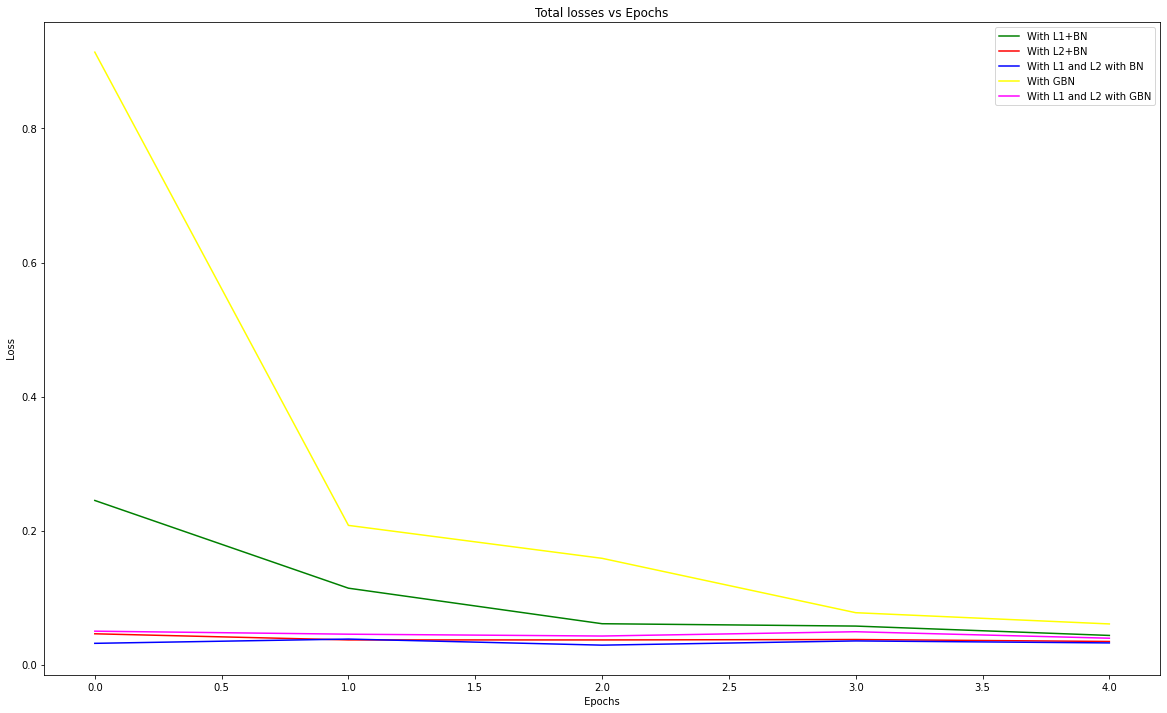

In [30]:
# 
plot_stat(total_losses, 'Loss')

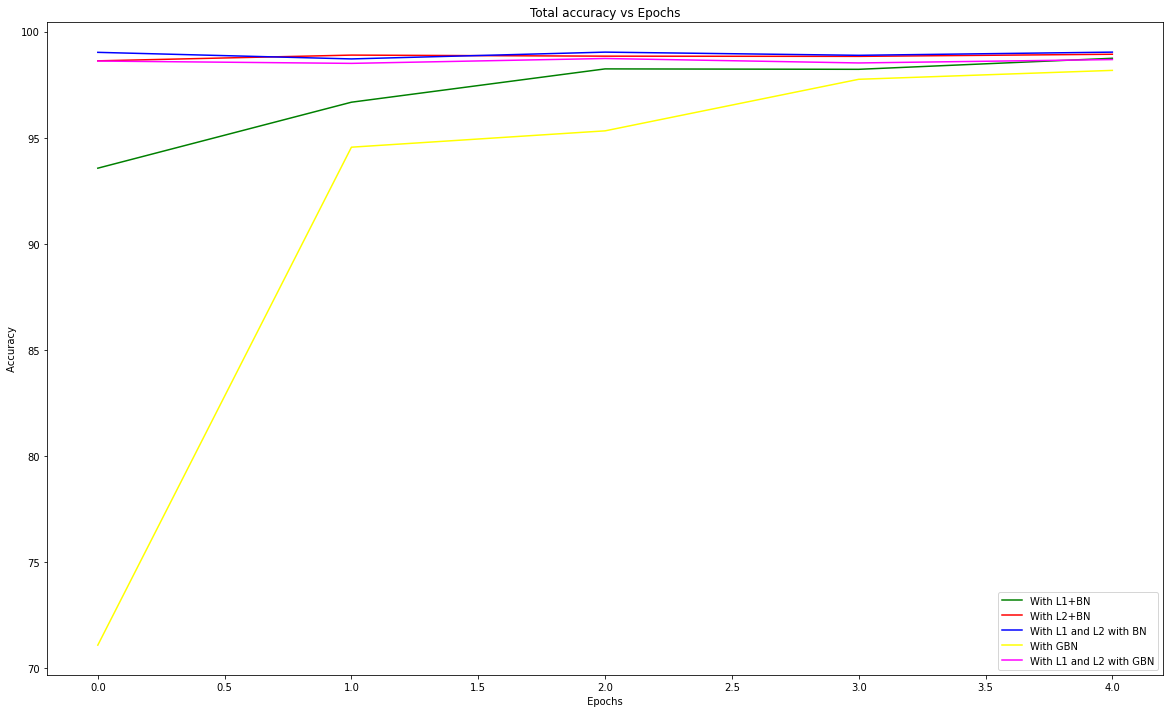

In [31]:
# 
plot_stat(total_accuracies, 'Acc')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


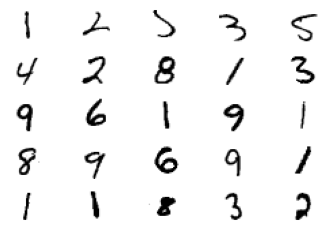

In [32]:
find_misclassified_image(model, save_path_gbn, device, train_loader, EPOCHS, "Ghost Batch Normalization")

## Summary:

A simple DNN with Total params=9,850 was created and trained for 25 epochs with L1, L2 Regularization, Batch Normalization and Ghost Batch Normalization. 

Following are the accuracy observed:

> 1. with L1 + BN => **99.29%**
2. with L2 + BN => **99.31%**
3. with L1 and L2 with BN => **99.47%**
4. with GBN => **98.9%**
5. with L1 and L2 with GBN => **99.33%**

Reference:
* GBN:  https://github.com/apple/ml-cifar-10-faster/blob/master/utils.py

